In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import tree
from scipy.stats import iqr
from scipy.stats import skew
from scipy.stats import kurtosis
from sklearn.model_selection import GridSearchCV

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier

In [3]:
valori_features = []
classi = []

path = ""

# calcoliamo le features di ogni timeseries

with open(path + 'UrbanObservatory.meta.csv', 'r', encoding='utf-8') as dati:
    for row in dati:
        riga = row.strip().split(',')
        classe = int(riga[8])
        classi.append(classe)
        valori = np.array(riga[9:]).astype(np.float)
        media = np.mean(valori)
        mediana = np.median(valori)
        maxim = np.max(valori)
        minim = np.min(valori)
        std_dev = np.std(valori)
        rms = np.sqrt(np.mean(np.square(valori)))
        quantile = np.quantile(valori, 0.4)
        i_q_r = iqr(valori)
        simmetria = skew(valori)
        curtosi = kurtosis(valori)
        rang = maxim - minim
        features = [rang, maxim, std_dev, rms, media, minim, quantile, mediana, curtosi, simmetria, i_q_r] 
        valori_features.append(features)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(valori_features, classi, test_size = 0.3, random_state = 100)

In [5]:
# trova i parametri ottimali di un classificatore

def optimizeParams(clf, params, X_train, y_train):
    clf_gs = GridSearchCV(clf, params, cv=5)
    clf_gs.fit(X_train, y_train)
    return clf_gs.best_estimator_

In [6]:
# calcola accuracy e f1 score di un classificatore

def metrics(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)*100
    f1 = f1_score(y_test, y_pred, average = 'macro')*100
    return [accuracy, f1]

In [26]:
# creiamo i classificatori e la lista di parametri la testare

clfs = []
params = []

decision_tree = DecisionTreeClassifier()
params_tree = {'criterion': ['gini', 'entropy'], 'max_depth' : np.arange(5, 25), 'max_features' : np.arange(1, 12)}
clfs.append(decision_tree)
params.append(params_tree)

svm = SVC()
params_svm = {'gamma' : ['scale', 'auto']}
clfs.append(svm)
params.append(params_svm)

knn = KNeighborsClassifier()
params_knn = {'n_neighbors' : np.arange(1, 25)}
clfs.append(knn)
params.append(params_knn)

lg = LogisticRegression()
params_lg = {'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'multi_class': ['ovr', 'auto']}
clfs.append(lg)
params.append(params_lg)

ridge = RidgeClassifier()
params_ridge = {'solver' : ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
clfs.append(ridge)
params.append(params_ridge)

gnb = GaussianNB()
clfs.append(gnb)

In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
# ottimizziamo i parametri e calcoliamo le metriche dei classificatori ottimizzati

clfs_best = []
metrics_best = []

for clf, param in zip(clfs, params):
    clf_best = optimizeParams(clf, param, X_train, y_train)
    clfs_best.append(clf_best)
    metrics_best.append(metrics(clf_best, X_test, y_test))

clfs_best.append(gnb)
gnb.fit(X_train, y_train)
metrics_best.append(metrics(gnb, X_test, y_test))

In [30]:
# metriche dei classificatori standard

metrics_standard = []

for clf in clfs:
    clf.fit(X_train, y_train)
    metrics_standard.append(metrics(clf, X_test, y_test))

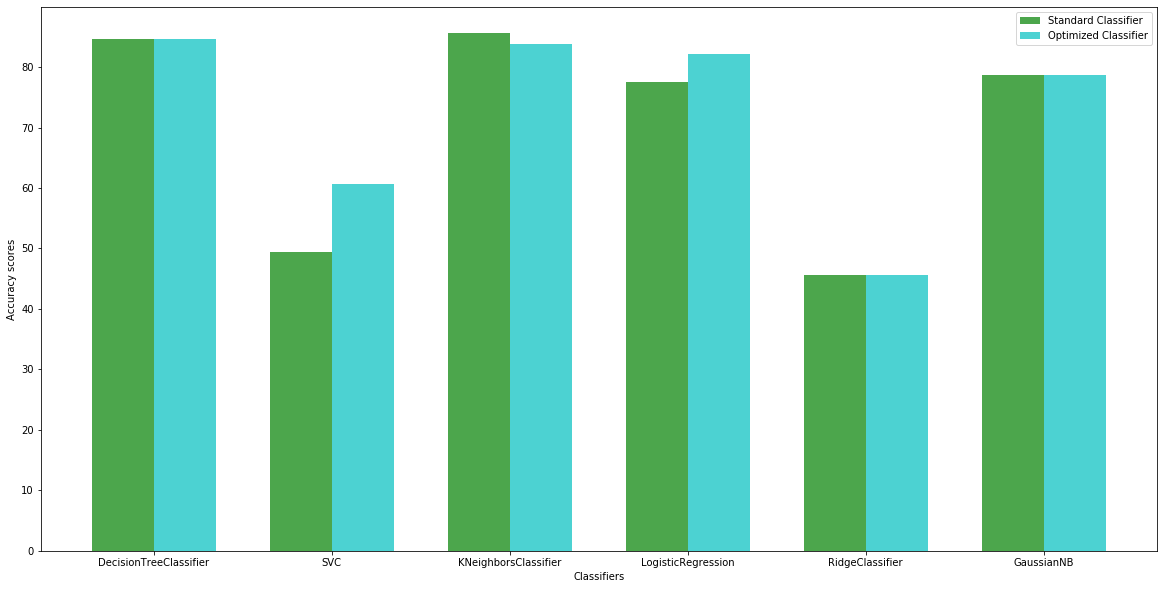

In [31]:
# plottiamo le accuracy a confronto

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 6
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

standard_clf = ax.bar(index, [y[0] for y in metrics_standard], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Standard Classifier')
optimized_clf = ax.bar(index + bar_width, [y[0] for y in metrics_best], bar_width, alpha=opacity, color='c', error_kw=error_config, label='Optimized Classifier')
labels = [clf.__class__.__name__ for clf in clfs]

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()

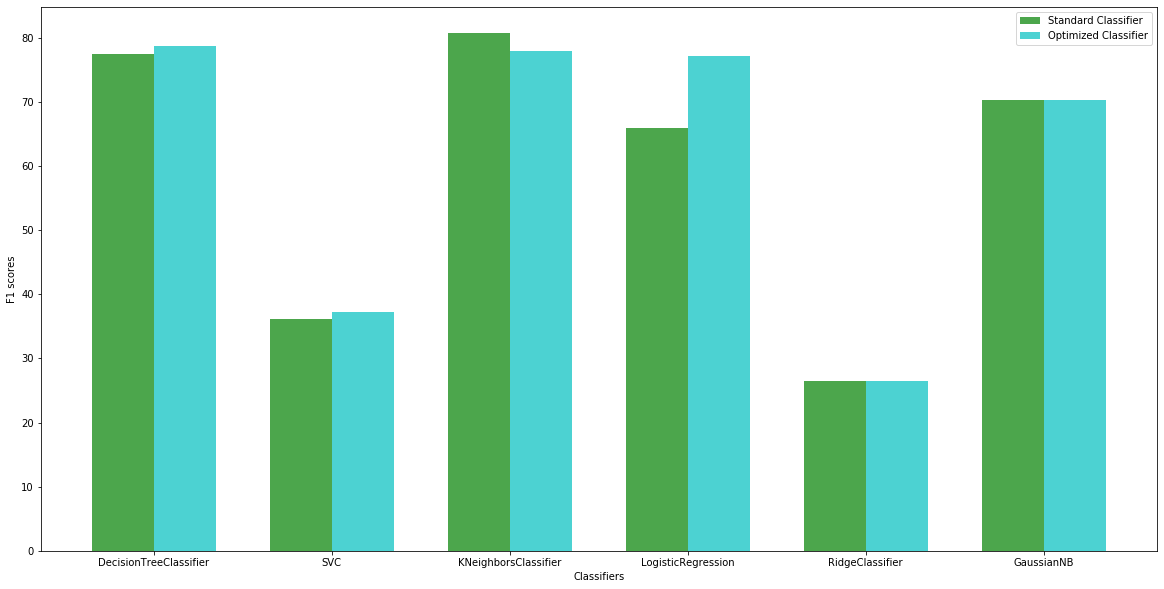

In [32]:
# f1 score a confronto

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 6
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

standard_clf = ax.bar(index, [y[1] for y in metrics_standard], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Standard Classifier')
optimized_clf = ax.bar(index + bar_width, [y[1] for y in metrics_best], bar_width, alpha=opacity, color='c', error_kw=error_config, label='Optimized Classifier')
labels = [clf.__class__.__name__ for clf in clfs]

ax.set_xlabel('Classifiers')
ax.set_ylabel('F1 scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()

In [13]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier

In [35]:
# creiamo un bagging ensemble per ogni tipologia di classificatore (prendiamo come base la variante ottimizzata)

bagging_ensembles = []
metrics_bagging = []

for clf in clfs_best:
    ensemble = BaggingClassifier(base_estimator = clf, n_estimators = 100, random_state = 100)
    bagging_ensembles.append(ensemble)
    ensemble.fit(X_train, y_train)
    metrics_bagging.append(metrics(ensemble, X_test, y_test))

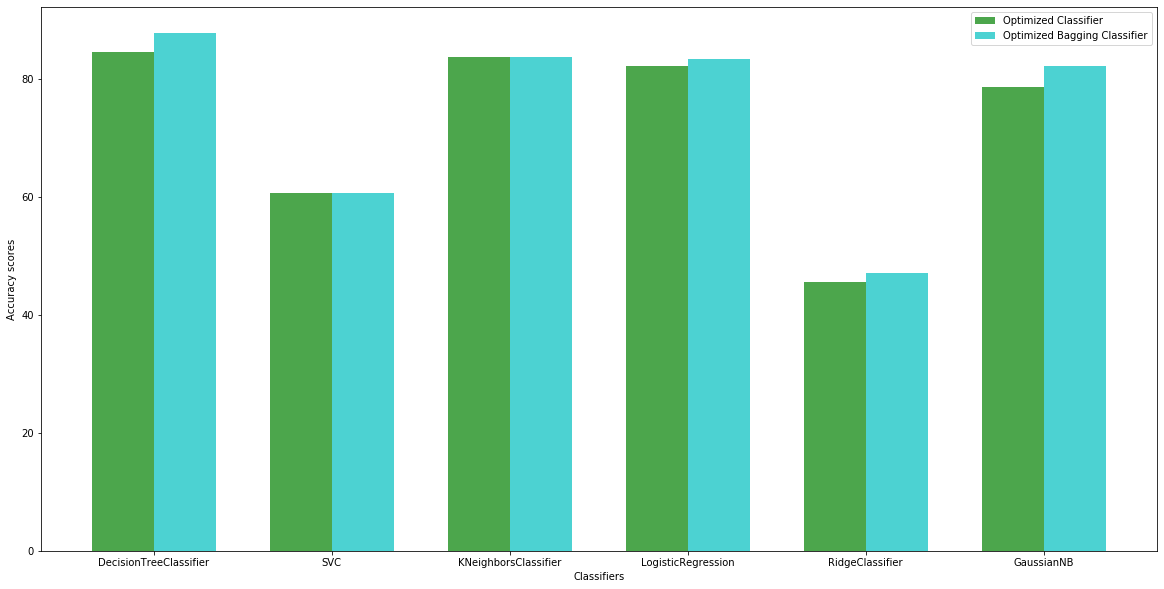

In [36]:
# accuracy a confronto

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 6
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

standard_clf = ax.bar(index, [y[0] for y in metrics_best], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Optimized Classifier')
optimized_clf = ax.bar(index + bar_width, [y[0] for y in metrics_bagging], bar_width, alpha=opacity, color='c', error_kw=error_config, label='Optimized Bagging Classifier')
labels = [clf.__class__.__name__ for clf in clfs]

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()

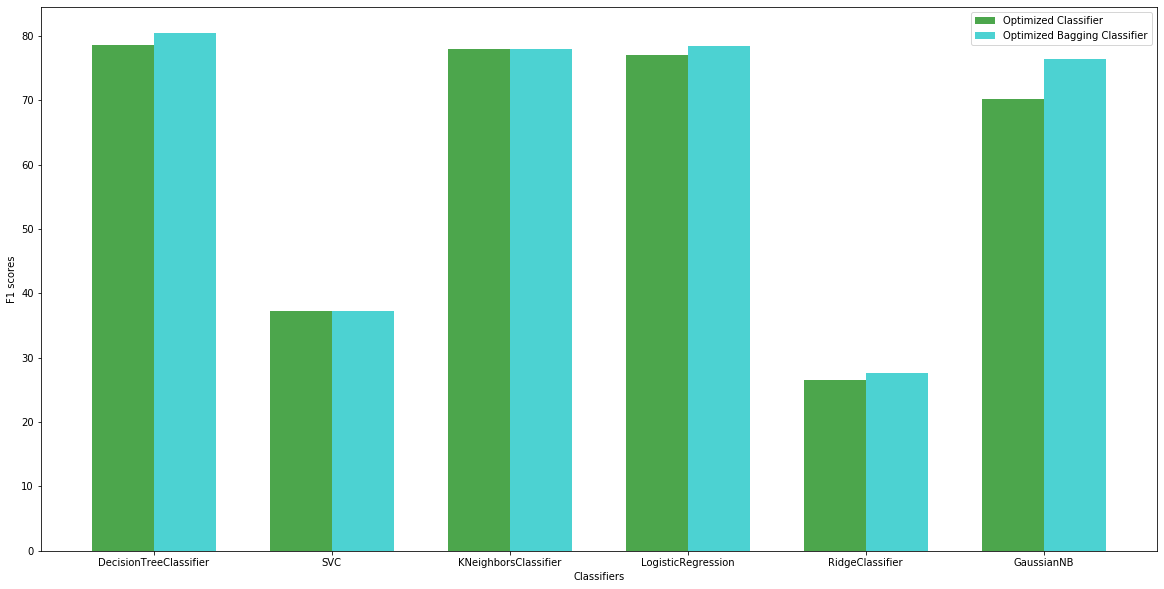

In [37]:
# f1 score

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 6
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

standard_clf = ax.bar(index, [y[1] for y in metrics_best], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Optimized Classifier')
optimized_clf = ax.bar(index + bar_width, [y[1] for y in metrics_bagging], bar_width, alpha=opacity, color='c', error_kw=error_config, label='Optimized Bagging Classifier')
labels = [clf.__class__.__name__ for clf in clfs]

ax.set_xlabel('Classifiers')
ax.set_ylabel('F1 scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()

In [38]:
# voting ensemble tra tutti i classificatori di base

estimators = []

for clf in clfs_best:
    estimators.append((clf.__class__.__name__, clf))

voting_ensemble = VotingClassifier(estimators)
voting_ensemble.fit(X_train, y_train)
voting_metrics = metrics(voting_ensemble, X_test, y_test)
print(voting_metrics)

[85.3125, 80.27967981419421]


In [39]:
!pip install mlxtend
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [40]:
# proviamo un paio di boosting ensembles, ottimizzandone i parametri

ada_boost = AdaBoostClassifier()
grad_boost = GradientBoostingClassifier()
params_ada = {'n_estimators': np.arange(25, 200, 5)}
params_grad = {'n_estimators': np.arange(50, 500, 10)}

ada_best = optimizeParams(ada_boost, params_ada, X_train, y_train)
grad_best = optimizeParams(grad_boost, params_grad, X_train, y_train)

# voting ensemble dei boosting classifiers

eclf = EnsembleVoteClassifier(clfs=[ada_best, grad_best], voting='soft')
eclf.fit(X_train, y_train)

labels = ['Ada Boost', 'Grad Boost', 'Ensemble']
metrics_boosting = []
boost_array = [ada_best, grad_best, eclf]

for clf in boost_array:
    metrics_boosting.append(metrics(clf, X_test, y_test))

In [47]:
# raggruppiamo tutte le metriche per plottarle

labels = ['DecisionTree Bagging', 'SVC Bagging', 'KNN Bagging', 'Logistic Bagging', 'Ridge Bagging', 'GaussianNB Bagging', 'Voting', 'AdaBoost', 'GradBoost', 'BoostingVoting']
metrics_combined = []

for met in metrics_bagging:
    metrics_combined.append(met)

metrics_combined.append(voting_metrics)

for met in metrics_boosting:
    metrics_combined.append(met)

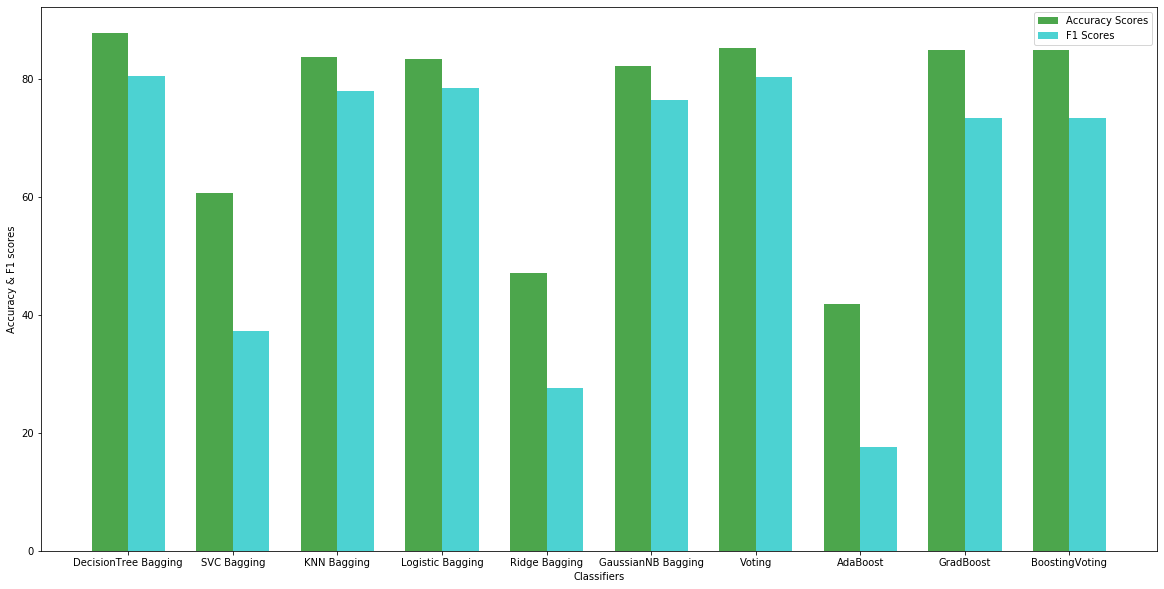

In [42]:
# accuracy e f1 score a confronto

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 10
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

standard_clf = ax.bar(index, [y[0] for y in metrics_combined], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Accuracy Scores')
optimized_clf = ax.bar(index + bar_width, [y[1] for y in metrics_combined], bar_width, alpha=opacity, color='c', error_kw=error_config, label='F1 Scores')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy & F1 scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()

In [43]:
!pip install mlens

from mlens.ensemble import SuperLearner
from itertools import combinations

[MLENS] backend: threading


In [44]:
# creiamo uno stacking classifier

names = ['DecisionTree', 'SVM', 'KNeighbors', 'Logistic', 'Ridge', 'GaussianNB']

# funzione che restituisce tutte le possibili combinazioni di classifiers

def zip_stacked_classifiers(*args):
    to_zip = []
    for arg in args:
        combined_items = sum([list(map(list, combinations(arg, i))) for i in range(len(arg) + 1)], [])
        combined_items = filter(lambda x: len(x) > 0, combined_items)
        to_zip.append(combined_items)
    
    return zip(to_zip[0], to_zip[1])

stacked_clf_list = zip_stacked_classifiers(clfs_best, names)

best_combination = [0.00, ""]
best_ensemble = None

# troviamo il miglior ensemble, utilizzando come meta classificatore un decision_tree

for clf in stacked_clf_list:
    
        ensemble = SuperLearner(random_state = 1000)
        ensemble.add(clf[0])
        ensemble.add_meta(decision_tree)
        ensemble.fit(np.array(X_train), np.array(y_train))
        preds = ensemble.predict(np.array(X_test))
        accuracy = accuracy_score(preds, np.array(y_test))
    
        if accuracy > best_combination[0]:
            best_combination[0] = accuracy
            best_combination[1] = clf[1]
            best_ensemble = ensemble
    
        print("Accuracy score: {:.3f} {}".format(accuracy, clf[1]))

print("\nBest stacking model is {} with accuracy of: {:.3f}".format(best_combination[1], best_combination[0]))

Accuracy score: 0.838 ['DecisionTree']
Accuracy score: 0.528 ['SVM']
Accuracy score: 0.838 ['KNeighbors']
Accuracy score: 0.822 ['Logistic']
Accuracy score: 0.456 ['Ridge']
Accuracy score: 0.787 ['GaussianNB']
Accuracy score: 0.850 ['DecisionTree', 'SVM']
Accuracy score: 0.853 ['DecisionTree', 'KNeighbors']
Accuracy score: 0.850 ['DecisionTree', 'Logistic']
Accuracy score: 0.853 ['DecisionTree', 'Ridge']
Accuracy score: 0.841 ['DecisionTree', 'GaussianNB']
Accuracy score: 0.847 ['SVM', 'KNeighbors']
Accuracy score: 0.787 ['SVM', 'Logistic']
Accuracy score: 0.569 ['SVM', 'Ridge']
Accuracy score: 0.806 ['SVM', 'GaussianNB']
Accuracy score: 0.844 ['KNeighbors', 'Logistic']
Accuracy score: 0.847 ['KNeighbors', 'Ridge']
Accuracy score: 0.828 ['KNeighbors', 'GaussianNB']
Accuracy score: 0.816 ['Logistic', 'Ridge']
Accuracy score: 0.844 ['Logistic', 'GaussianNB']
Accuracy score: 0.816 ['Ridge', 'GaussianNB']
Accuracy score: 0.847 ['DecisionTree', 'SVM', 'KNeighbors']
Accuracy score: 0.806 ['D

In [50]:
metrics_combined.append(metrics(best_ensemble, np.array(X_test), np.array(y_test)))
labels.append('Stacking Ensemble')

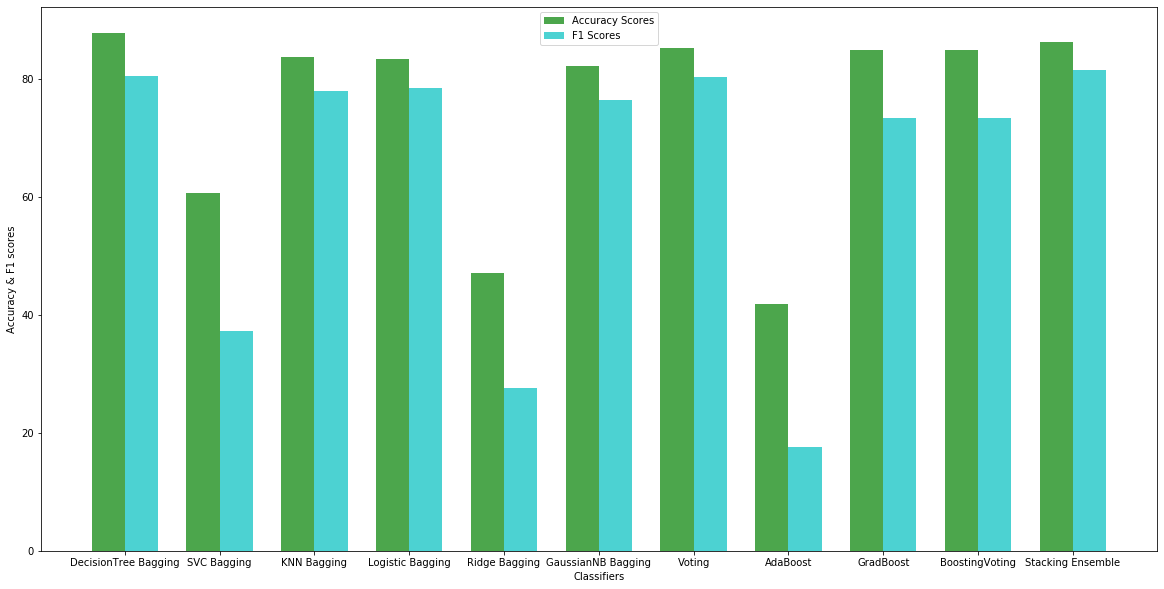

In [51]:
# grafico finale di accuracy e f1 scores

fig, ax = plt.subplots(figsize=(20,10))
n_groups = 11
index = np.arange(n_groups)
bar_width = 0.35

opacity = .7
error_config = {'ecolor': '0.3'}

standard_clf = ax.bar(index, [y[0] for y in metrics_combined], bar_width, alpha=opacity, color='g', error_kw=error_config, label='Accuracy Scores')
optimized_clf = ax.bar(index + bar_width, [y[1] for y in metrics_combined], bar_width, alpha=opacity, color='c', error_kw=error_config, label='F1 Scores')

ax.set_xlabel('Classifiers')
ax.set_ylabel('Accuracy & F1 scores')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels((labels))
ax.legend()

plt.show()